# Info

This a notebook made based on the vanilla version, but two big changes are made:
- dimension reduction will be done with PCA
- other clustering algorithm will be tested besides kmeans

# Import data

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
#import data
df_dig = pd.read_csv('data/Digital_Contact.csv', sep=';')

# Explore Data

In [3]:
df_dig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cust_ID       4000 non-null   int64  
 1   Email_Clicks  4000 non-null   int64  
 2   SM_Comments   4000 non-null   int64  
 3   App_Clicks    4000 non-null   int64  
 4   SM_Likes      4000 non-null   int64  
 5   SM_Shares     3961 non-null   float64
 6   SM_Clicks     4000 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 218.9 KB


- Dtypes seem appropriate
- 4000 entries, only 39 SM_Shares have missing data

Initial Suggestions:  
- turn Cust_ID as index
- explore correlations between features: missing values in SM_Shares may not be relevant if other feature is highly correlated

In [4]:
df_dig.head()

,Cust_ID,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,4,72,1,7,7,1.0,73
1,5,15,20,1,35,15.0,16
2,6,9,7,3,73,19.0,10
3,9,67,0,2,0,1.0,101
4,10,38,0,1,9,0.0,56


In [5]:
#Cust_IDs are unique?
len(df_dig['Cust_ID'].unique())

4000

Yes, we can turn index as Cust_ID.

In [6]:
#Cust_ID as index
df_dig.set_index('Cust_ID', inplace=True)
df_dig.head(5)

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1.0,73
5,15,20,1,35,15.0,16
6,9,7,3,73,19.0,10
9,67,0,2,0,1.0,101
10,38,0,1,9,0.0,56


In [7]:
#basic statistics
df_dig.describe()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
count,4000.00000,4000.000000,4000.000000,4000.000000,3961.000000,4000.000000
mean,25.76225,8.247750,19.526500,26.957000,8.355971,30.349250
std,23.65998,8.064963,34.237945,27.742658,8.696192,32.254974
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.00000,1.000000,2.000000,4.000000,1.000000,7.000000
50%,16.00000,4.000000,4.000000,11.000000,2.000000,15.000000
75%,36.00000,15.000000,7.000000,50.000000,16.000000,60.000000
max,86.00000,24.000000,127.000000,88.000000,26.000000,102.000000


All features seem to not be normally distributed, with values of mean around 2x the median - right tail.

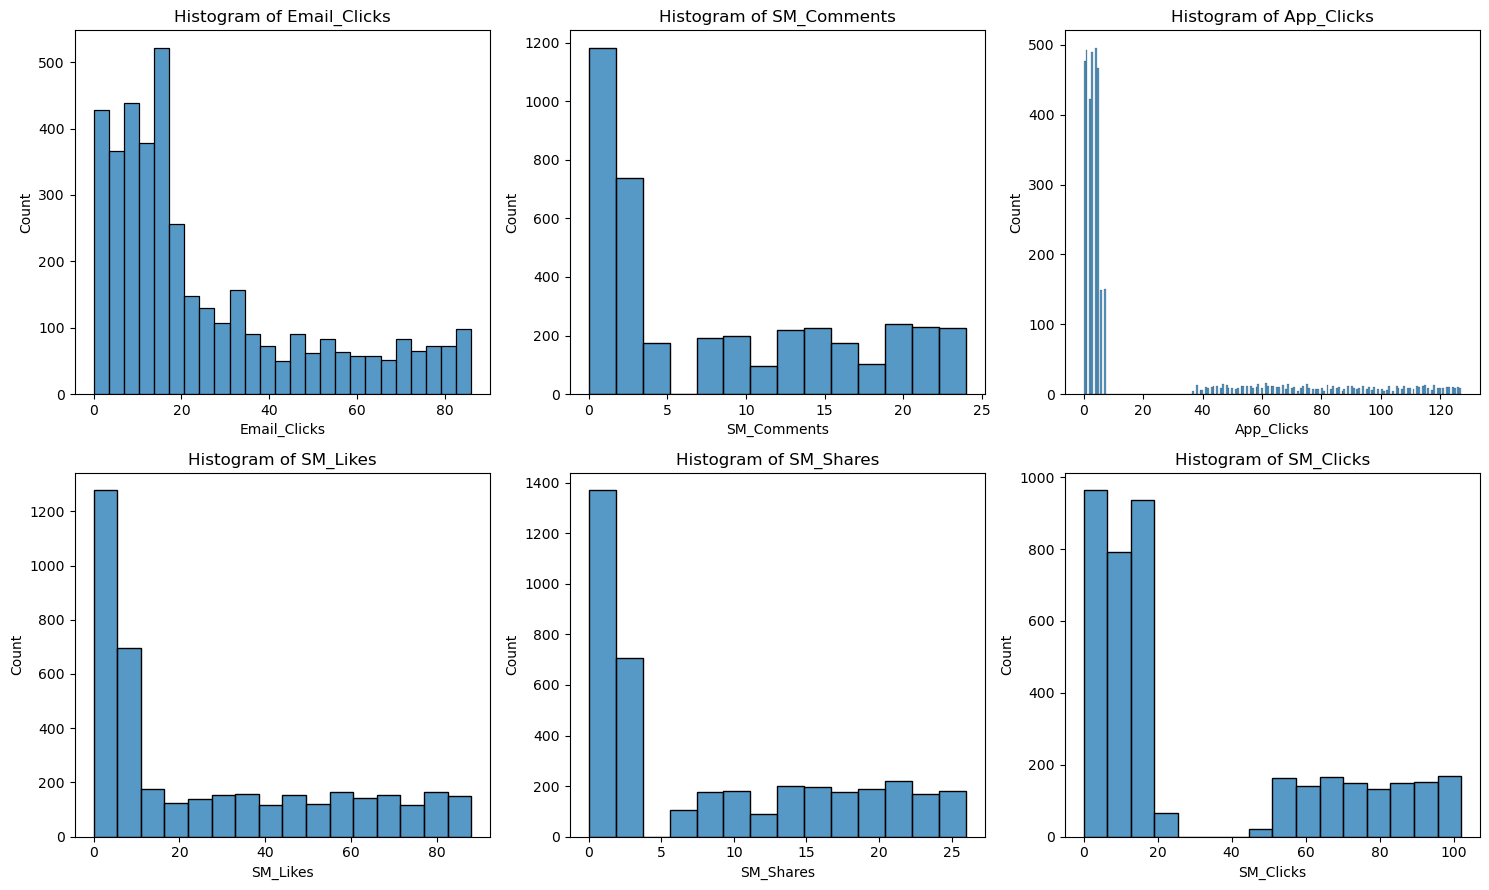

In [8]:
#look ate distribution of values
fig, axes = plt.subplots(2, 3, figsize=(15, 9))  # Create a 2x3 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to iterate over it

for i, column in enumerate(df_dig.columns):
        sns.histplot(df_dig[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

There is mostly an tendency for a group of people to interact very little (the majority) with social apps, and other group with constant distribution over a range of values.  

The resemblance of SM_Comments with SM_Shares is striking. We should investigate this - and all correlations.

No outliers observed.

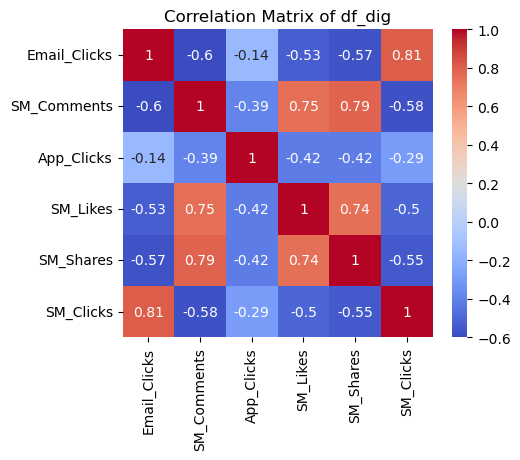

In [9]:
#correlatiomn between features
corr_matrix = df_dig.corr()
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(5, 4))  # Set the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')#, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of df_dig')
plt.show()

There are some high correlations:
- **SM** interactions are highly correlated 0.74-0.79  
  - with a notable **exception**: moderare inverse correlation of **SM_clicks**  

    
- **Email_Clicks** is **inversely** correlated with **all** other features, except a high correlation with **SM_clicks**  

     
- **App_clicks** are generally moderately **inversely** correlated with **all** other features.   

## Fill empty values
The SM_Shares empty values represent less than 1% of the dataset's entries, and can be deleted without impact on the overall conclusions.  
However, we have strong indications, from the task's requests that the KNN usage is indeed usefull, hinting that the original data may have been deleted intentionally, and KNN may help recover it.  

Since the data is not normally distributes, neither with extended right or left tails, filling SM_Shares with the values of mean or median would result in artifacts in the data do not represent it. A KNN algorithm will be used to fill the null values in SM_Shares.

In [10]:
# Select the relevant columns for KNN Imputer
cols_para_imputer = ['SM_Shares', 'SM_Comments', 'SM_Likes', 'SM_Clicks', 'Email_Clicks', 'App_Clicks']

# Subset do DataFrame with relevant columns
df_para_imputer = df_dig[cols_para_imputer]
# Configure of imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform')  # 'distance' também é uma opção
# Apply KNN Imputer, get matrix with filled values
df_imputed = imputer.fit_transform(df_para_imputer)

# convert to df
df_imputed = pd.DataFrame(df_imputed, columns=cols_para_imputer, index=df_dig.index)

# update original df
df_dig_clean = df_dig.copy()
df_dig_clean.update(df_imputed)  # Atualiza com os valores preenchidos

# round values to int
df_dig_clean['SM_Shares'] = df_dig_clean['SM_Shares'].round().astype('int')

print('Nr. of empty values:')
df_dig_clean.isna().sum()

Nr. of empty values:


Email_Clicks    0
SM_Comments     0
App_Clicks      0
SM_Likes        0
SM_Shares       0
SM_Clicks       0
dtype: int64

All empty entries were filled.

### Fill with KNN - Pedro version, less columns - comapare

In [11]:
# Select the relevant columns for KNN Imputer
cols_para_imputer2 = ['SM_Shares', 'SM_Comments', 'SM_Likes', 'SM_Clicks']

# Subset do DataFrame with relevant columns
df_para_imputer2 = df_dig[cols_para_imputer2]
# Configure of imputer
imputer2 = KNNImputer(n_neighbors=5, weights='uniform')  # 'distance' também é uma opção
# Apply KNN Imputer, get matrix with filled values
df_imputed2 = imputer2.fit_transform(df_para_imputer2)

# convert to df
df_imputed2 = pd.DataFrame(df_imputed2, columns=cols_para_imputer2, index=df_dig.index)

# update original df
df_dig2 = df_dig.copy()
df_dig2.update(df_imputed2)  # Atualiza com os valores preenchidos

# round values to int
df_dig2['SM_Shares'] = df_dig2['SM_Shares'].round().astype('int')

print('Nr. of empty values:')
df_dig2.isna().sum()

Nr. of empty values:


Email_Clicks    0
SM_Comments     0
App_Clicks      0
SM_Likes        0
SM_Shares       0
SM_Clicks       0
dtype: int64

In [12]:
#compare both versions
(df_dig2['SM_Shares'] != df_dig_clean['SM_Shares']).sum()

16

Only **16 entries** are different.  

# Advanced Clustering - PCA for dimension reduction and other clustering technique

In [303]:
#check original df
df_dig.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1.0,73
5,15,20,1,35,15.0,16
6,9,7,3,73,19.0,10
9,67,0,2,0,1.0,101
10,38,0,1,9,0.0,56


In [304]:
df_dig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Email_Clicks  4000 non-null   int64  
 1   SM_Comments   4000 non-null   int64  
 2   App_Clicks    4000 non-null   int64  
 3   SM_Likes      4000 non-null   int64  
 4   SM_Shares     3961 non-null   float64
 5   SM_Clicks     4000 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 218.8 KB


**Strategy**:  
- one way to reduce highly correlated dimensions is to apply **PCA**.
  - "capture a large amount of variance within a potentially much smaller number of dimensions"
  - is more objective than Options One and Two from above
  - dimenssion reduction is objectively quantifiable
- Before applying PCA we need to standardize the data

**Steps**:
- Standardization
- PCA
- run clustering

## Feature scaling (standardization)

In [305]:
#scale data before performing PCA
scaler=StandardScaler()
df_dig_std=pd.DataFrame(scaler.fit_transform(df_dig_clean), columns=df_dig.columns)
df_dig_std.index = df_dig.index
df_dig_std.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465
5,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925
6,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966
9,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657
10,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349


## PCA

In [306]:
#explore how much variance each PC captures
nr_features = df_dig_std.shape[1]
pca = PCA(n_components=nr_features)
df_dig_std_trans= pd.DataFrame(pca.fit_transform(df_dig_std))
df_dig_std_trans.head()

,0,1,2,3,4,5
0,-2.428741,-1.225402,0.201158,-0.540518,0.032379,-0.104025
1,1.626042,-0.403463,-0.539964,-0.268084,-0.559794,0.080899
2,1.866093,-0.309298,0.750337,0.330047,1.072342,-0.110763
3,-2.837209,-1.595188,-0.073097,-0.073472,0.063200,0.444548
4,-1.675945,-0.541437,0.020522,0.586268,0.008566,-0.369716


In [307]:
#recover index values
df_dig_std_trans.index = df_dig_clean.index
df_dig_std_trans.head()

,0,1,2,3,4,5
Cust_ID,,,,,,
4,-2.428741,-1.225402,0.201158,-0.540518,0.032379,-0.104025
5,1.626042,-0.403463,-0.539964,-0.268084,-0.559794,0.080899
6,1.866093,-0.309298,0.750337,0.330047,1.072342,-0.110763
9,-2.837209,-1.595188,-0.073097,-0.073472,0.063200,0.444548
10,-1.675945,-0.541437,0.020522,0.586268,0.008566,-0.369716


In [308]:
# Print the results
print('PCA Summary')
print('No. of features: ', df_dig_std_trans.shape[1])
print('No. of samples: ', df_dig_std_trans.shape[0])
print('No. of components: ', pca.n_components_)
print('Explained variance ratio: ', pca.explained_variance_ratio_)


PCA Summary
No. of features:  6
No. of samples:  4000
No. of components:  6
Explained variance ratio:  [0.60586862 0.25640614 0.04455278 0.03773459 0.03447368 0.02096419]


In [309]:
#let's analyze how many components we should keep
#plot cumulative explained variance
cum_variance=[]
for i, value in enumerate(pca.explained_variance_ratio_):
    if i==0:
        cum_variance.append(value)
    else:
        cum_variance.append(value+cum_variance[i-1])
print('Cumulative variance ratio over PCs: ', cum_variance)

Cumulative variance ratio over PCs:  [0.6058686199346819, 0.8622747618722323, 0.9068275444444206, 0.9445621339396784, 0.9790358125715996, 1.0000000000000002]


With only **3 dimensions** we get more than **90% of the explained variance**.

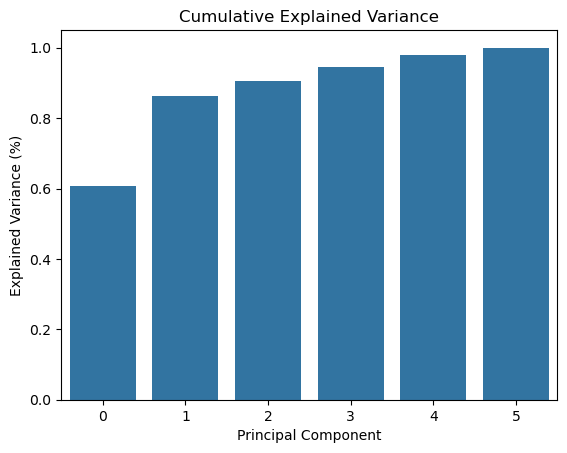

In [310]:
#Graphical representation of PCs' cumulative variance ratio
sns.barplot(data=cum_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.show()

### Final PCA model

In [311]:
#PCA with 3 components
n_components=2
pca_final = PCA(n_components=n_components)
df_dig_std_transfinal= pd.DataFrame(pca_final.fit_transform(df_dig_std))

df_dig_std_transfinal.index = df_dig_clean.index
df_dig_std_transfinal.columns += 1
df_dig_std_transfinal.head()

,1,2
Cust_ID,,
4,-2.428741,-1.225402
5,1.626042,-0.403463
6,1.866093,-0.309298
9,-2.837209,-1.595188
10,-1.675945,-0.541437


<Axes: ylabel='Count'>

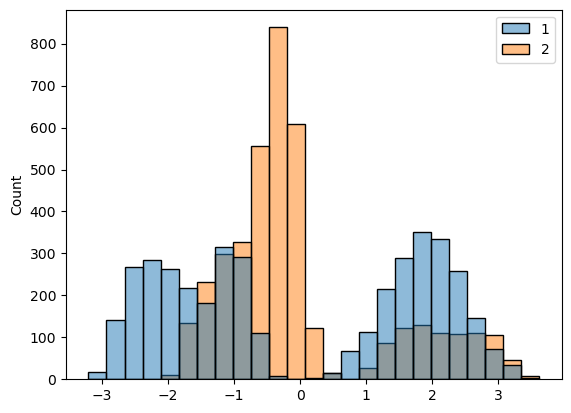

In [312]:
#look at data distribution
sns.histplot(data=df_dig_std_transfinal)

In [313]:
df_dig_std_transfinal.describe()

,1,2
count,4.000000e+03,4.000000e+03
mean,1.953993e-17,3.197442e-17
std,1.906861e+00,1.240492e+00
min,-3.202470e+00,-1.965948e+00
25%,-1.805630e+00,-7.471832e-01
50%,-7.163536e-01,-3.289835e-01
75%,1.857272e+00,6.885809e-02
max,3.606746e+00,3.620671e+00


Components 1 and 2 are distributed over two populations - as observed in the original data.  

K-means is not the appropriate clustering algorithm as it is better for data distributed in a globular manner.  

But let's confirm that with numbers...

### K-means for fun

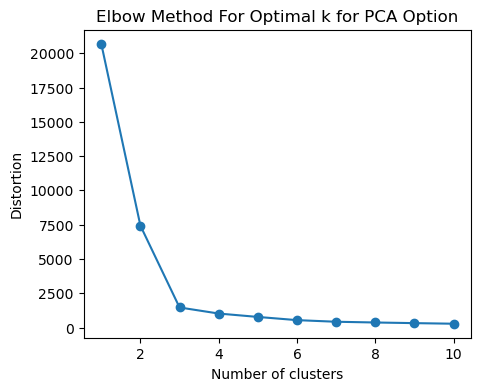

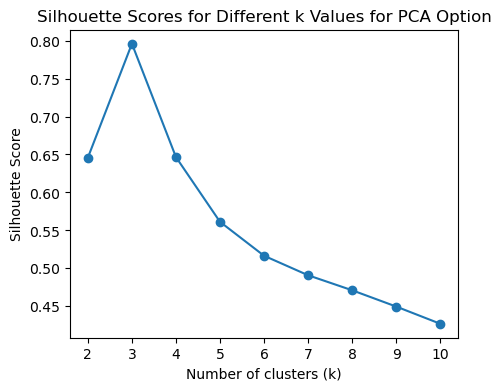

In [314]:
# Calculate distortion for a range of number of cluster
distortions = [] #for elbow method

#for silhouette method
features = df_dig_std_transfinal
silhouette_scores_digital = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels = km.fit_predict(features)  # Fit and predict simultaneously
    #calculate inertia score
    distortions.append(km.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores_digital.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method For Optimal k for PCA Option')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores_digital) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores_digital, marker='o')
    plt.title('Silhouette Scores for Different k Values for PCA Option')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

Ideal number of **clusters** also **3**.

In [315]:
#kmeans final model
n_clusters=3
km_pca_final = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km_pca_final.fit(df_dig_std_transfinal)
df_dig_std_transfinal['cluster_kmeans'] = km_pca_final.predict(df_dig_std_transfinal)
df_dig_std_transfinal.head()

,1,2,cluster_kmeans
Cust_ID,,,
4,-2.428741,-1.225402,0
5,1.626042,-0.403463,1
6,1.866093,-0.309298,1
9,-2.837209,-1.595188,0
10,-1.675945,-0.541437,0


In [316]:
df_dig_std_transfinal['cluster_kmeans'].unique()

array([0, 1, 2])

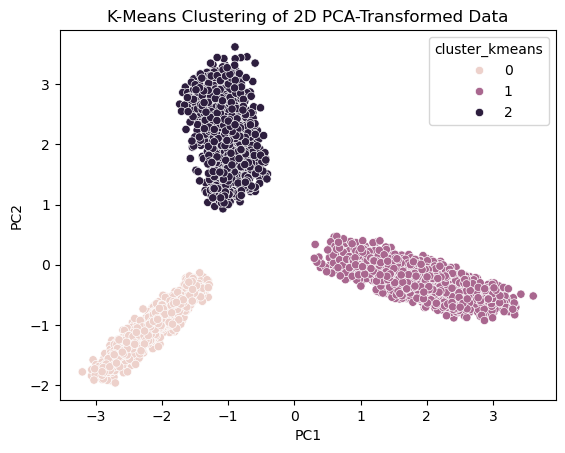

In [317]:
#look at clusters in 2D, with clustering with 2 components
sns.scatterplot(data=df_dig_std_transfinal, x=df_dig_std_transfinal[1], y=df_dig_std_transfinal[2], hue=df_dig_std_transfinal['cluster_kmeans'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering of 2D PCA-Transformed Data')
plt.show()

In [318]:
#apply cluster to original dataset
df_dig_wclusters = df_dig.copy()
df_dig_wclusters['cluster'] = df_dig_std_transfinal['cluster_kmeans']
df_dig_wclusters.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,cluster
Cust_ID,,,,,,,
4,72,1,7,7,1.0,73,0
5,15,20,1,35,15.0,16,1
6,9,7,3,73,19.0,10,1
9,67,0,2,0,1.0,101,0
10,38,0,1,9,0.0,56,0


In [319]:
#apply cluster to standardized dataset
df_dig_std_wclusters = df_dig_std.copy()
df_dig_std_wclusters['cluster'] = df_dig_std_transfinal['cluster_kmeans']
print(len(df_dig_std_wclusters))
df_dig_std_wclusters.head()

4000


,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,cluster
Cust_ID,,,,,,,
4,1.954504,-0.898784,-0.365912,-0.719451,-0.846507,1.322465,0
5,-0.454928,1.457380,-0.541178,0.289951,0.764408,-0.444925,1
6,-0.708553,-0.154732,-0.482756,1.659854,1.224669,-0.630966,1
9,1.743150,-1.022792,-0.511967,-0.971802,-0.846507,2.190657,0
10,0.517299,-1.022792,-0.541178,-0.647351,-0.961573,0.795349,0


## kmeans Model Evaluation

In [320]:
#import vanilla metrics
vanilla_metrics = pd.read_csv('exported_data/df_scores_kmeans.csv')
vanilla_metrics = vanilla_metrics.iloc[:,1:3]
vanilla_metrics

,distortion,silhouette_score
0,4752.322811,0.624604
1,2766.588088,0.662143
2,2254.958204,0.702768


In [321]:
distortion = distortions[2]
silhouette_score = silhouette_scores_digital[1]

new_data = pd.DataFrame({
    'distortion': [distortion],
    'silhouette_score': [silhouette_score]
})

vanilla_metrics = pd.concat([vanilla_metrics, new_data], ignore_index=True)


print('Distortion: ', distortion)
print('Silhouette Score: ', silhouette_score)
vanilla_metrics

Distortion:  1461.1050088750717
Silhouette Score:  0.7959514629212358


,distortion,silhouette_score
0,4752.322811,0.624604
1,2766.588088,0.662143
2,2254.958204,0.702768
3,1461.105009,0.795951


### Compare performance of using different number of components

With 2 components:  
Distortion:  1461
Silhouette Score:  0.796  

With 3 components:  
Distortion:  2527
Silhouette Score:  0.731  

With 4 components:   
Distortion:  3425  
Silhouette Score:  0.681  

With 5 components:   
Distortion:  4252  
Silhouette Score:  0.646

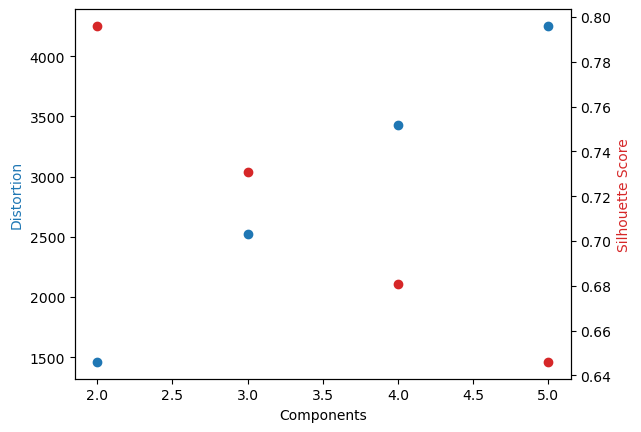

In [322]:
#plot comparisons

#create df
pca_components_performance = pd.DataFrame({'components': [2, 3, 4, 5], 'distortion': [1461, 2527, 3425, 4252], 'shilhouette_score': [0.796, 0.731, 0.681, 0.646]})



# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

#'distortion' on the left y-axis
ax1.set_xlabel('Components')
ax1.set_ylabel('Distortion', color='tab:blue')
scatter1 = ax1.scatter(pca_components_performance['components'], pca_components_performance['distortion'], color='tab:blue')

#y-axis for 'shilhouette_score'
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
scatter2 = ax2.scatter(pca_components_performance['components'], pca_components_performance['shilhouette_score'], color='tab:red')


plt.show()

Clearly, as we add components to the clustering, it's performance deacreses. Ideal to use 2 PCs, that capture 86% of the data variance.

### Visualization of vanilla clusters

In [323]:
#import data
vanilla_df=pd.read_csv('exported_data/df_dig_two_scaled.csv', index_col=0)
vanilla_df.head()

,Email_Clicks,App_Clicks,SM_Clicks,SM_interactions,cluster
Cust_ID,,,,,
4,1.954504,-0.365912,1.322465,-0.821581,0
5,-0.454928,-0.541178,-0.444925,0.837246,1
6,-0.708553,-0.482756,-0.630966,0.909931,1
9,1.743150,-0.511967,2.190657,-0.947034,0
10,0.517299,-0.541178,0.795349,-0.877239,0


In [324]:
#add vanilla clusters to pca-transformed data
df_dig_std_transfinal['vanilla_clusters'] = vanilla_df['cluster']
df_dig_std_transfinal.head()

,1,2,cluster_kmeans,vanilla_clusters
Cust_ID,,,,
4,-2.428741,-1.225402,0,0
5,1.626042,-0.403463,1,1
6,1.866093,-0.309298,1,1
9,-2.837209,-1.595188,0,0
10,-1.675945,-0.541437,0,0


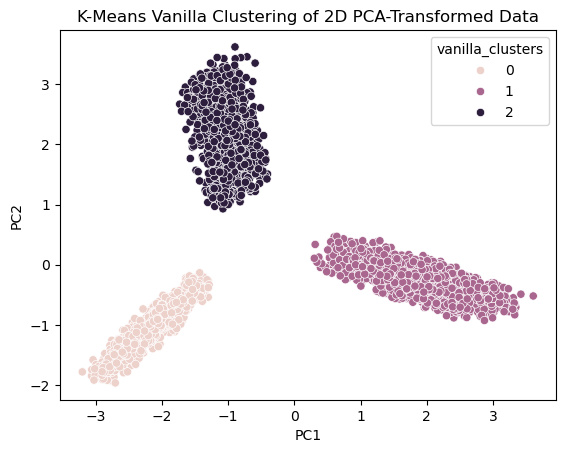

In [325]:
#look at clusters in 2D, with clustering with 2 components
sns.scatterplot(data=df_dig_std_transfinal, x=df_dig_std_transfinal[1], y=df_dig_std_transfinal[2], hue=df_dig_std_transfinal['vanilla_clusters'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Vanilla Clustering of 2D PCA-Transformed Data')
plt.show()

In [326]:
sum(df_dig_std_transfinal['vanilla_clusters'] == df_dig_std_transfinal['cluster_kmeans']) / len(df_dig_std_transfinal)

1.0

**clustering is the same!!!!!?????**

**Run PCA